In [1]:
import os
import sys
sys.path.append(os.path.abspath('..'))
from config import *

import random
import numpy as np
import torch
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# 蛾の種同定

種同定は、多様性調査において欠かせない作業の一つです。人工知能を活用した種同定システムを使用することで、市民が参加する多様性調査ネットワークに役立てることができ、全国規模の生態調査がより簡単に行えるようになります。本演習では、インターネットで集めた 50 種類の蛾の画像を使って、蛾の種同定モデルを構築する方法を学びます。

## 演習準備

### ライブラリ

本節で利用するライブラリを読み込みます。ライブラリの読み込み時に *ImportError* や *ModuleNotFoundError* が発生した場合は、該当するライブラリをインストールしてください。pytorch_grad_cam を読み込むときに ModuleNotFoundError が発生した場合は、[grad-cam](https://github.com/jacobgil/pytorch-grad-cam) パッケージをインストールしてください。

In [2]:
# image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL.Image

# machine learning
import sklearn.metrics
import torch
import torchvision

# grad-CAM visualization
import cv2
import pytorch_grad_cam

print(f'torch v{torch.__version__}; torchvision v{torchvision.__version__}')

torch v2.5.1+cu121; torchvision v0.20.1+cu121


ライブラリのインポート時に、*ImportError* や *ModuleNotFoundError* が発生した場合、必要なライブラリがインストールされていない可能性があります。該当するライブラリをインストールすることで、エラーなく実行できるようになります。

### データセット

本演習では、Kaggle において CC0 ライセンスのもとで配布された [MOTHS IMAGE DATASET-CLASSIFICATION](https://www.kaggle.com/datasets/gpiosenka/moths-image-datasetclassification) を利用します。このデータセットにはインターネットで集められた 50 種類の蛾の画像が 224 &times; 224 の正方形に変更した画像が用意されて、訓練サブセット、検証サブセットおよびテストサブセットに分けられています（{numref}`fig-moths_dataset_example`）。訓練サブセットには種によって枚数が異なるが 100 枚から 170 枚前後の画像が含まれています。検証サブセットよびテストサブセットについては、それぞれの種には 5 枚の画像が含まれています。


```{figure} ../_static/moths_dataset.jpg
---
name: fig-moths_dataset_example
---
MOTHS IMAGE DATASET CLASSIFICATION に含まれる 50 種の蛾の画像例。
```

Kaggle で配布されているオリジナルのデータセットについて、画像を保存しているフォルダ名にスペースが含まれています。スペースが含まれると操作ミスが起こりやすいため、本演習ではスペースをすべてアンダーバー「_」に置換したものを利用します。

修正済みのデータセットは、Jupyter Notebook 上では、次のコマンドを実行することでダウンロードできます。


```bash
!wget https://dl.biopapyrus.jp/data/moths.zip
!unzip moths.zip
```

### 画像前処理

物体分類用のニューラルネットワークアーキテクチャの多くは、正方形の画像を入力として受け取るように設計されています。例えば、本節で使用する ResNet-18 では、224×224 ピクセルの正方形画像を入力として想定しています[^resnet18_input]。また、PyTorch ではすべてのデータをテンソル形式で扱う必要があります。そのため、畳み込みニューラルネットワークに画像を入力する前に、画像サイズを適切に調整し、テンソル型に変換するなどの前処理を行う必要があります。

これらの前処理は次のように定義します。なお、本節で使用する画像データは、すでにネットワークの入力サイズに合わせて調整されているため、画像サイズを変更する必要はありません。


[^resnet18_input]: https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html

In [3]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

画像データは通常、0 から 255 の範囲の整数値で表現されていますが、前処理の段階でこれを正規化します。正規化により、画像データの値は平均約 0.5、標準偏差約 0.23 の範囲に変換され、モデルの学習を効率的に進めることができます。なお、正規化の際に平均を 0.50、分散を 0.23 のような切りの良い数値にしない理由は、これから利用する torchvision.models が提供する訓練済みモデルが、特定の数値（例えば平均 0.485、標準偏差 0.229）で訓練されているためです。そのため、この訓練済みモデルに合わせて正規化を行います。

なお、独自のアーキテクチャをゼロから訓練する際に、これらの正規化パラメータを訓練データの特徴に応じて決めたりする必要があります。

### 計算デバイス

計算デバイスを設定します。PyTorch が GPU を認識できる場合は GPU を利用し、認識できない場合は CPU を利用します。

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## モデル構築

本節では、物体分類を行うアーキテクチャとして ResNet18 を利用します。ResNet-18 は、深層学習のアーキテクチャの中でも比較的層が浅く、パラメーターの数も少ないため、訓練時間が速いという特徴があります。ResNet18 のアーキテクチャは、torchvision.models モジュールで提供されています。

なお、torchvision.models モジュールで提供されている ResNet-18 は、飛行機や車、人などの 1000 種類の一般的な物体を分類することを前提に設計されています。これに対して、本節では、画像を 50 種類の蛾のな目に分類するため、ResNet-18 の出力層のクラス数を 50 に修正する必要があります。この修正作業はモデルを呼び出すたびに行う必要があり、手間がかかります。そこで、一連の処理を関数化してから利用します。

In [5]:
def resnet18(num_classes, weights=None):
    model = torchvision.models.resnet18(weights='DEFAULT')
    in_features = model.fc.in_features
    model.fc = torch.nn.Linear(in_features, num_classes)
    if weights is not None:
        model.load_state_dict(torch.load(weights))
    return model

model = resnet18(50)

## モデル訓練

モデルが学習データを効率よく学習できるようにするため、損失関数（`criterion`）、学習アルゴリズム（`optimizer`）、学習率（`lr`）、および学習率を調整するスケジューラ（`lr_scheduler`）を設定します。

In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

次に、訓練データと検証データを読み込み、モデルが入力できる形式に整えます。

In [7]:
train_dataset = torchvision.datasets.ImageFolder('moths/train', transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

valid_dataset = torchvision.datasets.ImageFolder('moths/valid', transform=transform)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False)

準備が整ったら、訓練を開始します。訓練プロセスでは、訓練と検証を交互に繰り返します。訓練では、訓練データを使ってモデルのパラメータを更新し、その際の損失（誤差）を記録します。検証では、検証データを使ってモデルの予測性能（正解率）を計算し、その結果を記録します。このサイクルを繰り返すことで、モデルの精度を少しずつ向上させていきます。

In [8]:
model.to(device)

num_epochs = 10
metric_dict = []

for epoch in range(num_epochs):
    # training phase
    model.train()

    running_loss = 0.0
    n_correct_train = 0
    n_train_samples = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        _, predicted_labels = torch.max(outputs.data, 1)
        n_correct_train += torch.sum(predicted_labels == labels).item()
        n_train_samples += labels.size(0)
        running_loss +=  loss.item() / len(train_loader)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    lr_scheduler.step()


    # validation phase
    model.eval()
    
    n_correct_valid = 0
    n_valid_samples = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted_labels = torch.max(outputs.data, 1)
            n_correct_valid += torch.sum(predicted_labels == labels).item()
            n_valid_samples += labels.size(0)

    metric_dict.append({
        'epoch': epoch + 1,
        'train_loss': running_loss,
        'train_acc': n_correct_train / n_train_samples,
        'valid_acc': n_correct_valid / n_valid_samples
    })
  
    print(metric_dict[-1])

{'epoch': 1, 'train_loss': 1.0046157244841258, 'train_acc': 0.7315884727829598, 'valid_acc': 0.748}
{'epoch': 2, 'train_loss': 0.5041845037539799, 'train_acc': 0.8472782959766114, 'valid_acc': 0.768}
{'epoch': 3, 'train_loss': 0.30975207113557396, 'train_acc': 0.9096477794793262, 'valid_acc': 0.876}
{'epoch': 4, 'train_loss': 0.09965885195467206, 'train_acc': 0.9729917861617708, 'valid_acc': 0.976}
{'epoch': 5, 'train_loss': 0.04994811324816613, 'train_acc': 0.9867743282750939, 'valid_acc': 0.972}
{'epoch': 6, 'train_loss': 0.037556943463989446, 'train_acc': 0.991368508979535, 'valid_acc': 0.972}
{'epoch': 7, 'train_loss': 0.026553005856565306, 'train_acc': 0.9947097313100376, 'valid_acc': 0.972}
{'epoch': 8, 'train_loss': 0.0246313559398469, 'train_acc': 0.9954058192955589, 'valid_acc': 0.972}
{'epoch': 9, 'train_loss': 0.022797829798526244, 'train_acc': 0.9956842544897675, 'valid_acc': 0.972}
{'epoch': 10, 'train_loss': 0.02231286113667819, 'train_acc': 0.9955450368926633, 'valid_acc

訓練後、学習時の損失および検証性能の変化を可視化し、訓練が正しく行われたかどうかを確認します。

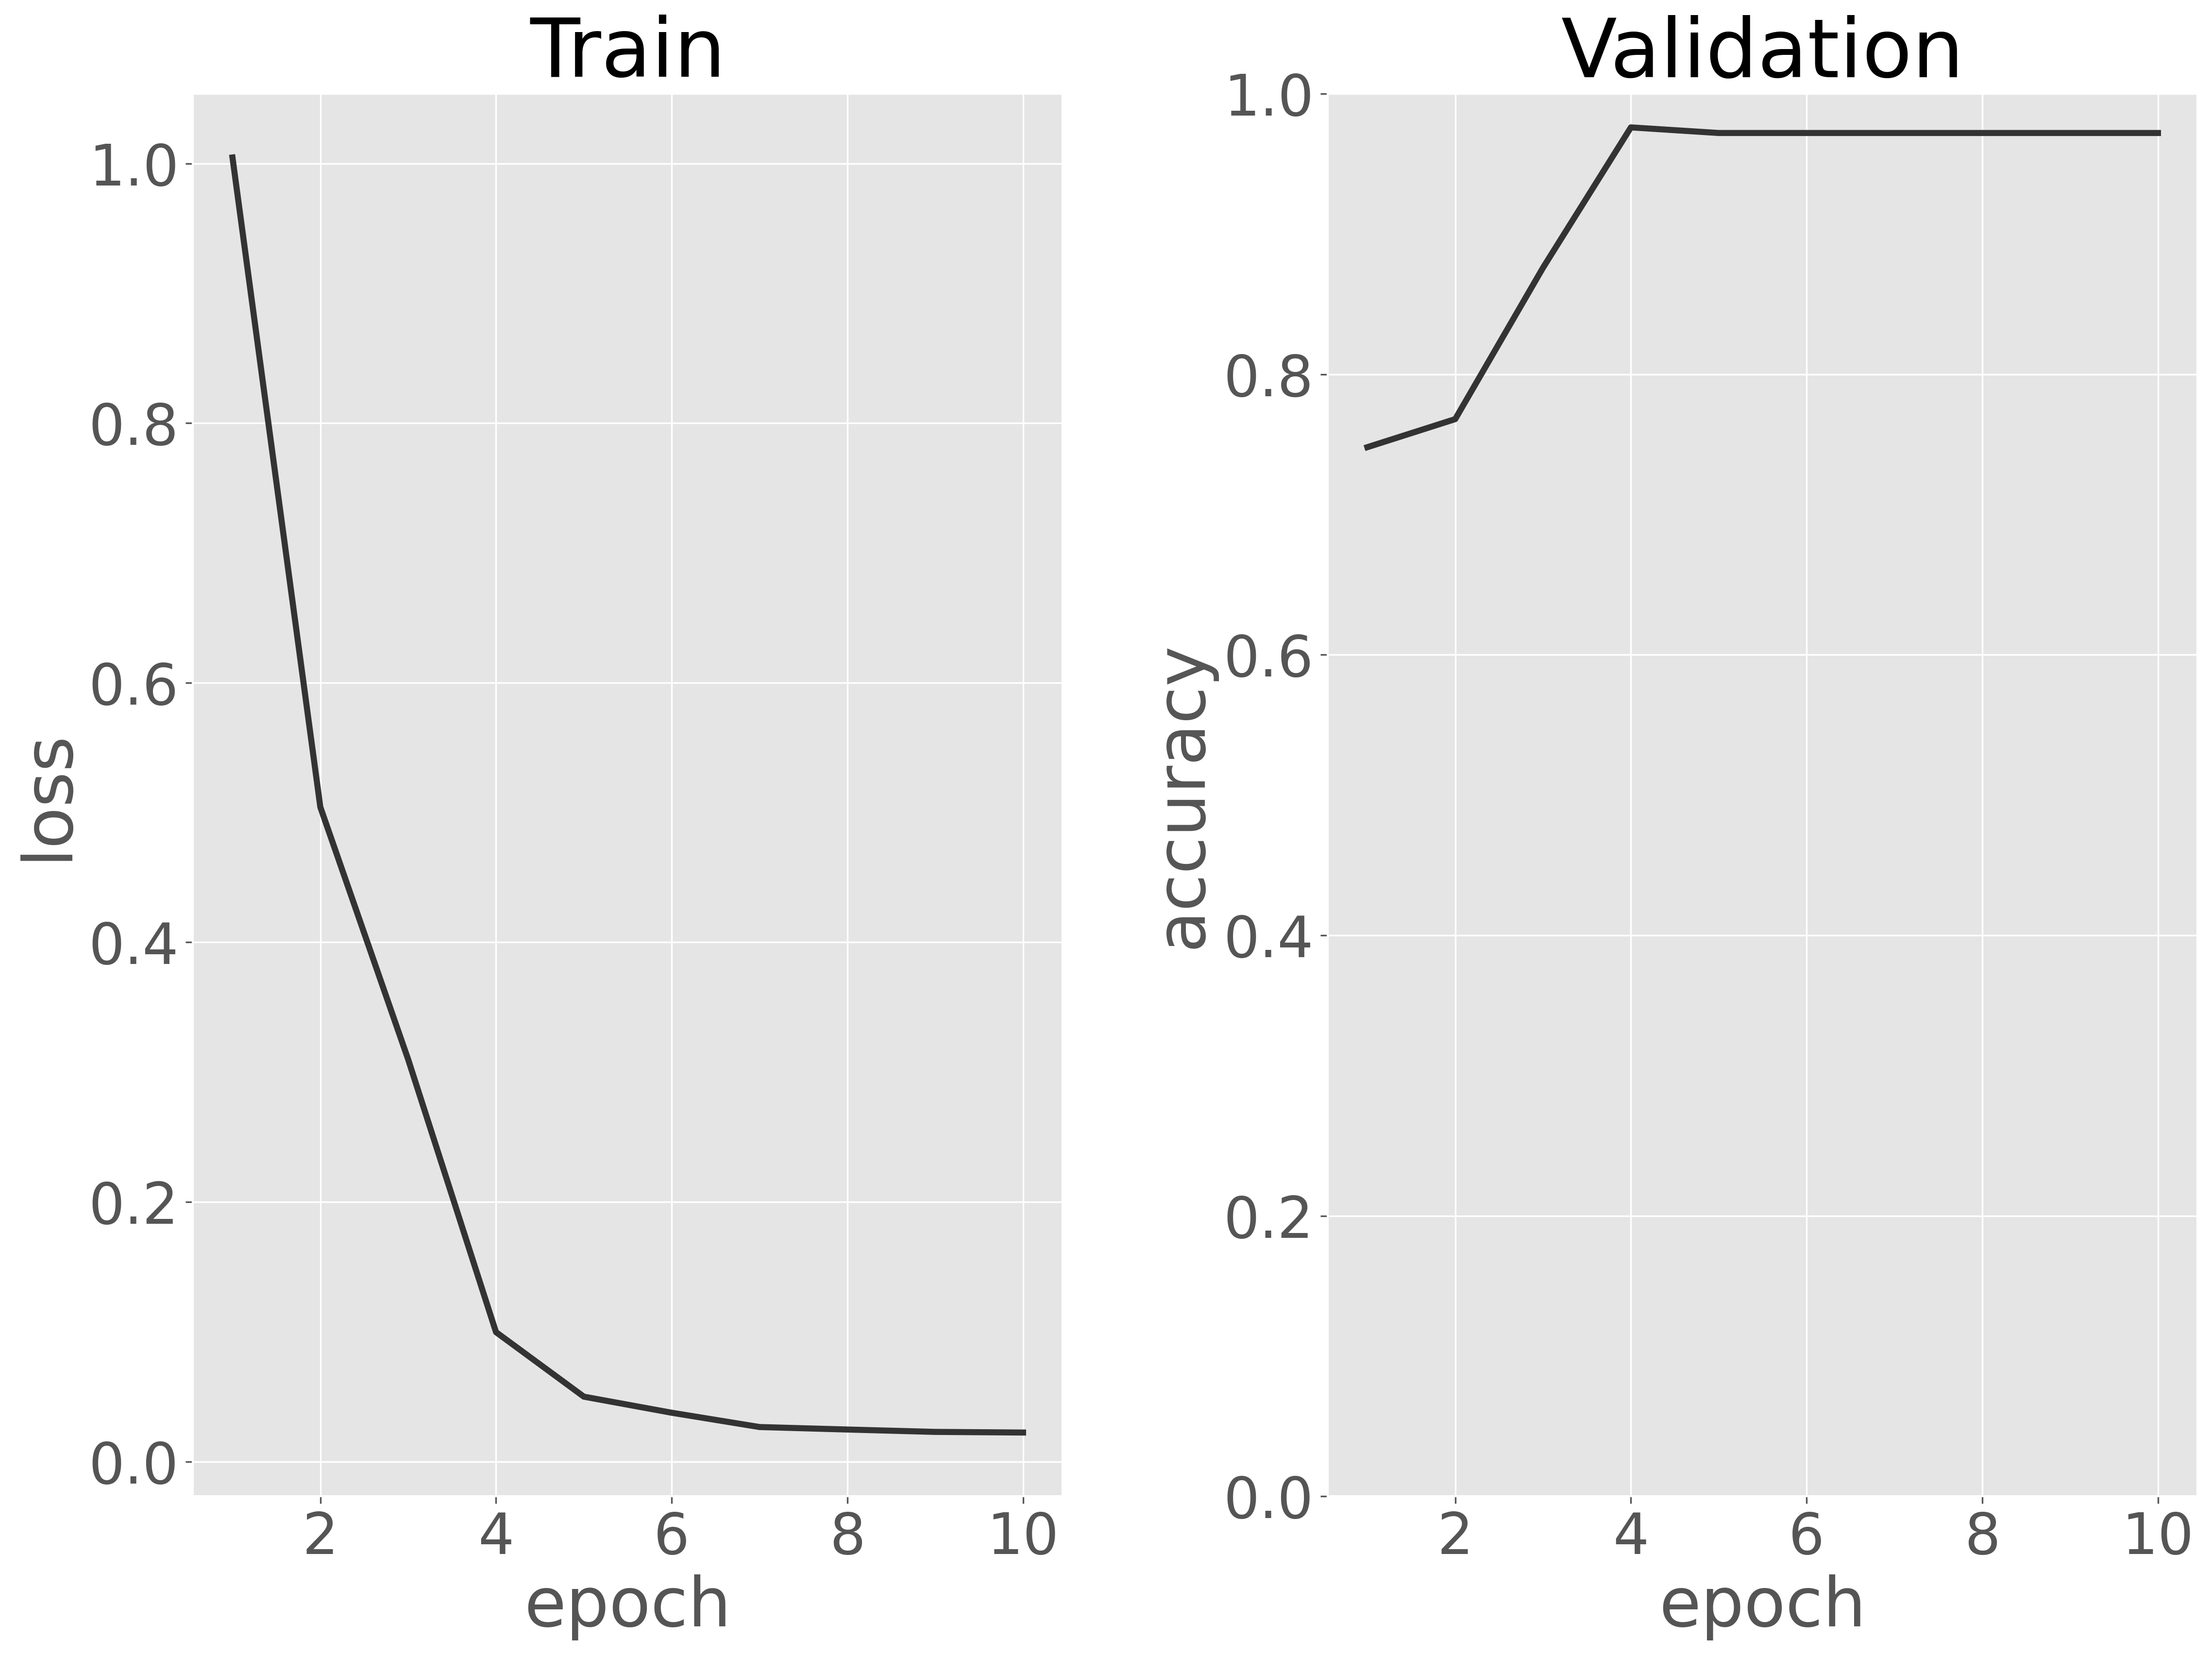

In [9]:
metric_dict = pd.DataFrame(metric_dict)

fig, ax = plt.subplots(1, 2)
ax[0].plot(metric_dict['epoch'], metric_dict['train_loss'])
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].set_title('Train')
ax[1].plot(metric_dict['epoch'], metric_dict['valid_acc'])
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].set_title('Validation')
plt.tight_layout()
fig.show()

可視化の結果から、エポックが増えると訓練データに対する損失が減少し、7 エポック前後で収束し始めたように見えます。また、検証データに対する分類性能（正解率）は、4 エポック目からすでにほぼ最大値に達したように見えます。

次に、上の手順を様々な深層ニューラルネットワークのアーキテクチャ（DenseNet や Inception など）に対して行います。それぞれのアーキテクチャの検証性能を見比べ、このデータセットにとって最適なアーキテクチャを決めます。ただし、本節ではモデル（アーキテクチャ）選択を行わずに、ResNet18 を最適なアーキテクチャとして採用し、次のステップに進みます。

次のステップでは、訓練サブセットと検証サブセットを統合し、最適なアーキテクチャを最初から訓練します。

In [10]:
!rm -rf moths/trainvalid

In [11]:
!mkdir moths/trainvalid
!cp -r moths/train/* moths/trainvalid
!cp -r moths/valid/* moths/trainvalid

最適なモデルを選択する段階で、数エポックの訓練だけでも十分に高い予測性能を獲得できたことがわかったので、ここでは訓練サブセットと検証サブセットを統合したデータに対して 5 エポックだけ訓練させます。

In [12]:
# model
model = resnet18(50)
model.to(device)

# training params
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00003)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# training data
train_dataset = torchvision.datasets.ImageFolder('moths/trainvalid', transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)

# training
num_epochs = 5
metric_dict = []

for epoch in range(num_epochs):
    model.train()

    running_loss = 0.0
    n_correct_train = 0
    n_train_samples = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        _, predicted_labels = torch.max(outputs.data, 1)
        n_correct_train += torch.sum(predicted_labels == labels).item()
        n_train_samples += labels.size(0)
        running_loss +=  loss.item() / len(train_loader)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    lr_scheduler.step()

    metric_dict.append({
        'epoch': epoch + 1,
        'train_loss': running_loss,
        'train_acc': n_correct_train / n_train_samples,
    })
  
    print(metric_dict[-1])
    

{'epoch': 1, 'train_loss': 1.5957862095006048, 'train_acc': 0.7153235571101844}
{'epoch': 2, 'train_loss': 0.4515699996823262, 'train_acc': 0.9226422709538544}
{'epoch': 3, 'train_loss': 0.24668986213703967, 'train_acc': 0.9588322346293556}
{'epoch': 4, 'train_loss': 0.14403747544593873, 'train_acc': 0.9812996098479753}
{'epoch': 5, 'train_loss': 0.13641240040280983, 'train_acc': 0.9815686802098749}


訓練が完了したら、訓練済みモデルの重みをファイルに保存します。

In [13]:
model = model.to('cpu')
torch.save(model.state_dict(), 'moths.pth')

## モデル評価

最適なモデルが得られたら、次にテストデータを用いてモデルを詳細に評価します。例えば、正解率の他に、適合率や再現率や F1 スコアなどを計算し、モデルを総合的に評価します。まず、テストデータをモデルに入力し、その予測結果を取得します。

In [14]:
test_dataset = torchvision.datasets.ImageFolder('moths/test', transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

model = resnet18(50, 'moths.pth')
model.to(device)
model.eval()


pred_labels = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, _labels = torch.max(outputs.data, 1)
        #print(_labels)
        pred_labels.extend(_labels.cpu().detach().numpy().tolist())
        true_labels.extend(labels.cpu().detach().numpy().tolist())

pred_labels = [test_dataset.classes[_] for _ in pred_labels]
true_labels = [test_dataset.classes[_] for _ in true_labels]

次に、予測結果とラベルを比較し、混同行列を作成します。これにより、間違いやすいカテゴリを特定することができます。

In [15]:
cm = sklearn.metrics.confusion_matrix(true_labels, pred_labels)
print(cm)

[[5 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]
 [0 0 5 ... 0 0 0]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 5 0]
 [0 0 0 ... 0 0 5]]


それぞれのクラスに対する適合率、再現率、F1 スコアなどは、scikit-learn ライブラリを利用して計算します。

In [17]:
pd.DataFrame(sklearn.metrics.classification_report(true_labels, pred_labels, output_dict=True))

ARCIGERA_FLOWER_MOTH  ATLAS_MOTH  BANDED_TIGER_MOTH  \
precision                   1.0         1.0                1.0   
recall                      1.0         1.0                1.0   
f1-score                    1.0         1.0                1.0   
support                     5.0         5.0                5.0   

           BIRD_CHERRY_ERMINE_MOTH  BLACK_RUSTIC_MOTH  BLAIRS_MOCHA  \
precision                      1.0                1.0           1.0   
recall                         1.0                1.0           1.0   
f1-score                       1.0                1.0           1.0   
support                        5.0                5.0           5.0   

           BLOTCHED_EMERALD_MOTH  BLUE_BORDERED_CARPET_MOTH  CINNABAR_MOTH  \
precision                    1.0                        1.0            1.0   
recall                       1.0                        1.0            1.0   
f1-score                     1.0                        1.0            1.0   
support                      5.0                        5.0            5.0   

           CLEARWING_MOTH  COMET_MOTH  DEATHS_HEAD_HAWK_MOTH  \
precision             1.0         1.0                    1.0   
recall                1.0         1.0                    1.0   
f1-score              1.0         1.0                    1.0   
support               5.0         5.0                    5.0   

           ELEPHANT_HAWK_MOTH  EMPEROR_GUM_MOTH  EMPEROR_MOTH  EYED_HAWK_MOTH  \
precision                 1.0               1.0           1.0             1.0   
recall                    1.0               1.0           1.0             1.0   
f1-score                  1.0               1.0           1.0             1.0   
support                   5.0               5.0           5.0             5.0   

           FIERY_CLEARWING_MOTH  GARDEN_TIGER_MOTH  HERCULES_MOTH  \
precision                   1.0                1.0            1.0   
recall                      1.0                1.0            1.0   
f1-score                    1.0                1.0            1.0   
support                     5.0                5.0            5.0   

           HORNET_MOTH  HUMMING_BIRD_HAWK_MOTH  IO_MOTH  JULY_BELLE_MOTH  \
precision          1.0                     1.0      1.0              1.0   
recall             1.0                     1.0      1.0              1.0   
f1-score           1.0                     1.0      1.0              1.0   
support            5.0                     5.0      5.0              5.0   

           KENTISH_GLORY_MOTH  LACE_BORDER_MOTH  LEOPARD_MOTH  LUNA_MOTH  \
precision                 1.0               1.0           1.0        1.0   
recall                    1.0               1.0           1.0        1.0   
f1-score                  1.0               1.0           1.0        1.0   
support                   5.0               5.0           5.0        5.0   

           MADAGASCAN_SUNSET_MOTH  MAGPIE_MOTH  MUSLIN_MOTH  \
precision                     1.0          1.0          1.0   
recall                        1.0          1.0          1.0   
f1-score                      1.0          1.0          1.0   
support                       5.0          5.0          5.0   

           OLEANDER_HAWK_MOTH  OWL_MOTH  PALPITA_VITREALIS_MOTH  \
precision                 1.0       1.0                     1.0   
recall                    1.0       1.0                     1.0   
f1-score                  1.0       1.0                     1.0   
support                   5.0       5.0                     5.0   

           PEACH_BLOSSOM_MOTH  PLUME_MOTH  POLYPHEMUS_MOTH  \
precision                 1.0         1.0              1.0   
recall                    1.0         1.0              1.0   
f1-score                  1.0         1.0              1.0   
support                   5.0         5.0              5.0   

           PURPLE_BORDERED_GOLD_MOTH  RED_NECKED_FOOTMAN_MOTH  REGAL_MOTH  \
precision                        1.0                      

## 推論


推論を行う際には、訓練や評価時と同様に、torchvision.models モジュールから ResNet18 のアーキテクチャを読み込み、出力層のクラス数を設定します。その後、`load_state_dict` メソッドを使用して訓練済みの重みファイルをモデルにロードします。これらの処理はすでに関数化（`resnet18`）されているため、その関数を利用して簡単に実行できます。

In [18]:
labels = [_ for _ in test_dataset.classes]

model = resnet18(50, 'moths.pth')
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

このモデルを使用して推論を行います。まず、ARCIGERA_FLOWER_MOTH に分類されている画像を 1 枚指定し、訓練時と同じ前処理を行います。その後、前処理した画像をモデルに入力し、モデルから予測結果が出力されます。

In [19]:
image_path = 'moths/test/ARCIGERA_FLOWER_MOTH/1.jpg'

image = PIL.Image.open(image_path).convert('RGB')
input_tensor = transform(image).unsqueeze(0).to(device)

with torch.no_grad():
    score = model(input_tensor)[0]

print(labels)
print(score)

['ARCIGERA_FLOWER_MOTH', 'ATLAS_MOTH', 'BANDED_TIGER_MOTH', 'BIRD_CHERRY_ERMINE_MOTH', 'BLACK_RUSTIC_MOTH', 'BLAIRS_MOCHA', 'BLOTCHED_EMERALD_MOTH', 'BLUE_BORDERED_CARPET_MOTH', 'CINNABAR_MOTH', 'CLEARWING_MOTH', 'COMET_MOTH', 'DEATHS_HEAD_HAWK_MOTH', 'ELEPHANT_HAWK_MOTH', 'EMPEROR_GUM_MOTH', 'EMPEROR_MOTH', 'EYED_HAWK_MOTH', 'FIERY_CLEARWING_MOTH', 'GARDEN_TIGER_MOTH', 'HERCULES_MOTH', 'HORNET_MOTH', 'HUMMING_BIRD_HAWK_MOTH', 'IO_MOTH', 'JULY_BELLE_MOTH', 'KENTISH_GLORY_MOTH', 'LACE_BORDER_MOTH', 'LEOPARD_MOTH', 'LUNA_MOTH', 'MADAGASCAN_SUNSET_MOTH', 'MAGPIE_MOTH', 'MUSLIN_MOTH', 'OLEANDER_HAWK_MOTH', 'OWL_MOTH', 'PALPITA_VITREALIS_MOTH', 'PEACH_BLOSSOM_MOTH', 'PLUME_MOTH', 'POLYPHEMUS_MOTH', 'PURPLE_BORDERED_GOLD_MOTH', 'RED_NECKED_FOOTMAN_MOTH', 'REGAL_MOTH', 'ROSY_MAPLE_MOTH', 'ROSY_UNDERWING_MOTH', 'RUSTY_DOT_PEARL_MOTH', 'SCHORCHED_WING_MOTH', 'SIXSPOT_BURNET_MOTH', 'SQUARE_SPOT_RUSTIC_MOTH', 'SUSSEX_EMERALD_MOTH', 'SWALLOW_TAILED_MOTH', 'VESTAL_MOTH', 'WHITE_LINED_SPHINX_MOTH', 

このように、モデルの出力値は実数値として得られます。最も高い数値を持つクラスが予測結果（予測ラベル）となります。しかし、このままでは出力値が理解しにくいため、予測値を合計が 1.0 になるように修正します。これにより、出力値が確率として解釈できるようになります。

In [20]:
prob = torch.softmax(score, axis=0).cpu().detach().numpy()
print(prob)

[9.8894638e-01 1.4303587e-04 5.0943207e-05 3.5695368e-06 9.1851471e-05
 2.2192789e-05 1.8790353e-05 1.2118129e-04 2.5357507e-05 3.2433507e-04
 1.4510355e-05 8.5590327e-05 1.8389881e-04 1.9370884e-04 5.5050339e-05
 1.6476655e-03 7.3440638e-06 3.5848323e-05 5.8745226e-04 1.2835086e-04
 1.0521823e-03 5.4405820e-05 3.1161457e-05 3.1117583e-03 9.8801620e-06
 8.0561213e-06 2.8865328e-05 4.9472219e-06 1.3363946e-05 1.0444268e-04
 4.7281803e-05 5.7531935e-05 1.7290387e-05 1.0886099e-03 1.0344471e-05
 4.4479116e-04 8.0463506e-05 2.2197977e-05 2.7093794e-05 9.0377616e-05
 5.8704431e-05 1.3082088e-05 4.3713953e-04 3.9188795e-05 1.4436833e-04
 2.4056731e-05 1.5377069e-05 4.1779604e-05 1.6703794e-04 6.7208108e-05]


ソフトマックス関数を使用して出力を変換することにより、確率のような値が得られます。この変換によって、各クラスに対する予測確率が計算されます。必要に応じて、Pandas などのライブラリを利用して、予測結果を見やすい形式に整えます。

In [21]:
output = pd.DataFrame({
    'class': labels,
    'probability': prob 
})
output

class  probability
0        ARCIGERA_FLOWER_MOTH     0.988946
1                  ATLAS_MOTH     0.000143
2           BANDED_TIGER_MOTH     0.000051
3     BIRD_CHERRY_ERMINE_MOTH     0.000004
4           BLACK_RUSTIC_MOTH     0.000092
5                BLAIRS_MOCHA     0.000022
6       BLOTCHED_EMERALD_MOTH     0.000019
7   BLUE_BORDERED_CARPET_MOTH     0.000121
8               CINNABAR_MOTH     0.000025
9              CLEARWING_MOTH     0.000324
10                 COMET_MOTH     0.000015
11      DEATHS_HEAD_HAWK_MOTH     0.000086
12         ELEPHANT_HAWK_MOTH     0.000184
13           EMPEROR_GUM_MOTH     0.000194
14               EMPEROR_MOTH     0.000055
15             EYED_HAWK_MOTH     0.001648
16       FIERY_CLEARWING_MOTH     0.000007
17          GARDEN_TIGER_MOTH     0.000036
18              HERCULES_MOTH     0.000587
19                HORNET_MOTH     0.000128
20     HUMMING_BIRD_HAWK_MOTH     0.001052
21                    IO_MOTH     0.000054
22            JULY_BELLE_MOTH     0.000031
23         KENTISH_GLORY_MOTH     0.003112
24           LACE_BORDER_MOTH     0.000010
25               LEOPARD_MOTH     0.000008
26                  LUNA_MOTH     0.000029
27     MADAGASCAN_SUNSET_MOTH     0.000005
28                MAGPIE_MOTH     0.000013
29                MUSLIN_MOTH     0.000104
30         OLEANDER_HAWK_MOTH     0.000047
31                   OWL_MOTH     0.000058
32     PALPITA_VITREALIS_MOTH     0.000017
33         PEACH_BLOSSOM_MOTH     0.001089
34                 PLUME_MOTH     0.000010
35            POLYPHEMUS_MOTH     0.000445
36  PURPLE_BORDERED_GOLD_MOTH     0.000080
37    RED_NECKED_FOOTMAN_MOTH     0.000022
38                 REGAL_MOTH     0.000027
39            ROSY_MAPLE_MOTH     0.000090
40        ROSY_UNDERWING_MOTH     0.000059
41       RUSTY_DOT_PEARL_MOTH     0.000013
42        SCHORCHED_WING_MOTH     0.000437
43        SIXSPOT_BURNET_MOTH     0.000039
44    SQUARE_SPOT_RUSTIC_MOTH     0.000144
45        SUSSEX_EMERALD_MOTH     0.000024
46        SWALLOW_TAILED_MOTH     0.000015
47                VESTAL_MOTH     0.000042
48    WHITE_LINED_SPHINX_MOTH     0.000167
49   WHITE_SPOTTED_SABLE_MOTH     0.000067

もう一例を見てみましょう。LUNA_MOTH に分類された画像をモデルに入力し、推論を行います。

In [22]:
image_path = 'moths/test/LUNA_MOTH/5.jpg'

image = PIL.Image.open(image_path).convert('RGB')
input_tensor = transform(image).unsqueeze(0).to(device)

with torch.no_grad():
    score = model(input_tensor)[0]

pd.DataFrame({
    'class': labels,
    'probability': torch.softmax(score, axis=0).cpu().detach().numpy() 
})

class  probability
0        ARCIGERA_FLOWER_MOTH     0.000022
1                  ATLAS_MOTH     0.000004
2           BANDED_TIGER_MOTH     0.000006
3     BIRD_CHERRY_ERMINE_MOTH     0.000005
4           BLACK_RUSTIC_MOTH     0.000013
5                BLAIRS_MOCHA     0.000003
6       BLOTCHED_EMERALD_MOTH     0.000067
7   BLUE_BORDERED_CARPET_MOTH     0.000020
8               CINNABAR_MOTH     0.000013
9              CLEARWING_MOTH     0.000005
10                 COMET_MOTH     0.004691
11      DEATHS_HEAD_HAWK_MOTH     0.000020
12         ELEPHANT_HAWK_MOTH     0.000005
13           EMPEROR_GUM_MOTH     0.000031
14               EMPEROR_MOTH     0.000007
15             EYED_HAWK_MOTH     0.000003
16       FIERY_CLEARWING_MOTH     0.000004
17          GARDEN_TIGER_MOTH     0.000013
18              HERCULES_MOTH     0.000035
19                HORNET_MOTH     0.000058
20     HUMMING_BIRD_HAWK_MOTH     0.000027
21                    IO_MOTH     0.000044
22            JULY_BELLE_MOTH     0.000004
23         KENTISH_GLORY_MOTH     0.000012
24           LACE_BORDER_MOTH     0.000003
25               LEOPARD_MOTH     0.000014
26                  LUNA_MOTH     0.994447
27     MADAGASCAN_SUNSET_MOTH     0.000035
28                MAGPIE_MOTH     0.000021
29                MUSLIN_MOTH     0.000004
30         OLEANDER_HAWK_MOTH     0.000025
31                   OWL_MOTH     0.000011
32     PALPITA_VITREALIS_MOTH     0.000008
33         PEACH_BLOSSOM_MOTH     0.000030
34                 PLUME_MOTH     0.000018
35            POLYPHEMUS_MOTH     0.000032
36  PURPLE_BORDERED_GOLD_MOTH     0.000014
37    RED_NECKED_FOOTMAN_MOTH     0.000005
38                 REGAL_MOTH     0.000007
39            ROSY_MAPLE_MOTH     0.000081
40        ROSY_UNDERWING_MOTH     0.000005
41       RUSTY_DOT_PEARL_MOTH     0.000008
42        SCHORCHED_WING_MOTH     0.000005
43        SIXSPOT_BURNET_MOTH     0.000021
44    SQUARE_SPOT_RUSTIC_MOTH     0.000003
45        SUSSEX_EMERALD_MOTH     0.000033
46        SWALLOW_TAILED_MOTH     0.000032
47                VESTAL_MOTH     0.000009
48    WHITE_LINED_SPHINX_MOTH     0.000007
49   WHITE_SPOTTED_SABLE_MOTH     0.000008

## 分類根拠の可視化

畳み込みニューラルネットワーク（CNN）を利用した分類において、畳み込み層で抽出された特徴マップが分類に寄与しています。そのため、最後の畳み込み層で得られた特徴マップと、それぞれの特徴量に対する重みを用いて可視化を行うことで、モデルの分類根拠を明らかにすることができます。

ここでは、いくつかの可視化アルゴリズムを用いて、モデルの判断根拠を可視化します。可視化には Python の grad-cam パッケージが必要です。必要に応じてインストールし、grad-cam の[チュートリアル](https://jacobgil.github.io/pytorch-gradcam-book/introduction.html)を参考にして、Grad-CAM を計算し、可視化するための関数を定義します。

In [27]:
def viz(image_path):
    # load models
    labels = [_ for _ in test_dataset.classes]
    model = resnet18(50, 'moths.pth')
    model.to(device)
    model.eval()

    # load image
    image = PIL.Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    rgb_img = cv2.imread(image_path, 1)[:, :, ::-1]
    rgb_img = np.float32(np.array(image)) / 255
    
    # Grad-CAM
    with pytorch_grad_cam.GradCAM(model=model, target_layers=[model.layer4]) as cam:
        cam.batch_size = 32
        grayscale_cam = cam(input_tensor=input_tensor, targets=None,aug_smooth=True, eigen_smooth=True)
        grayscale_cam = grayscale_cam[0, :]
        cam_image = pytorch_grad_cam.utils.image.show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
        prob = torch.softmax(cam.outputs[0], axis=0).cpu().detach().numpy()

    gb_model = pytorch_grad_cam.GuidedBackpropReLUModel(model=model, device=device)
    gb = gb_model(input_tensor, target_category=None)
    cam_mask = np.stack([grayscale_cam, grayscale_cam, grayscale_cam], axis=-1)
    cam_gb = pytorch_grad_cam.utils.image.deprocess_image(cam_mask * gb)
    gb = pytorch_grad_cam.utils.image.deprocess_image(gb)
    
    # plot
    fig, ax = plt.subplots(2, 2)
    ax[0, 0].imshow(rgb_img)
    ax[0, 0].axis('off')
    ax[0, 0].set_title('Original Image', fontsize=16)
    ax[0, 1].imshow(cam_image)
    ax[0, 1].axis('off')
    ax[0, 1].set_title('Grad-CAM', fontsize=16)
    ax[1, 0].imshow(gb)
    ax[1, 0].axis('off')
    ax[1, 0].set_title('Guided Backpropagation', fontsize=16)
    ax[1, 1].imshow(cam_gb)
    ax[1, 1].axis('off')
    ax[1, 1].set_title('Guided Grad-CAM', fontsize=16)
    fig.show()


次に、いくつかの画像をこの関数に代入し、モデルの予測結果とその判断根拠を可視化します。これにより、モデルがどの部分に注目して分類を行ったのかが視覚的に示されます。

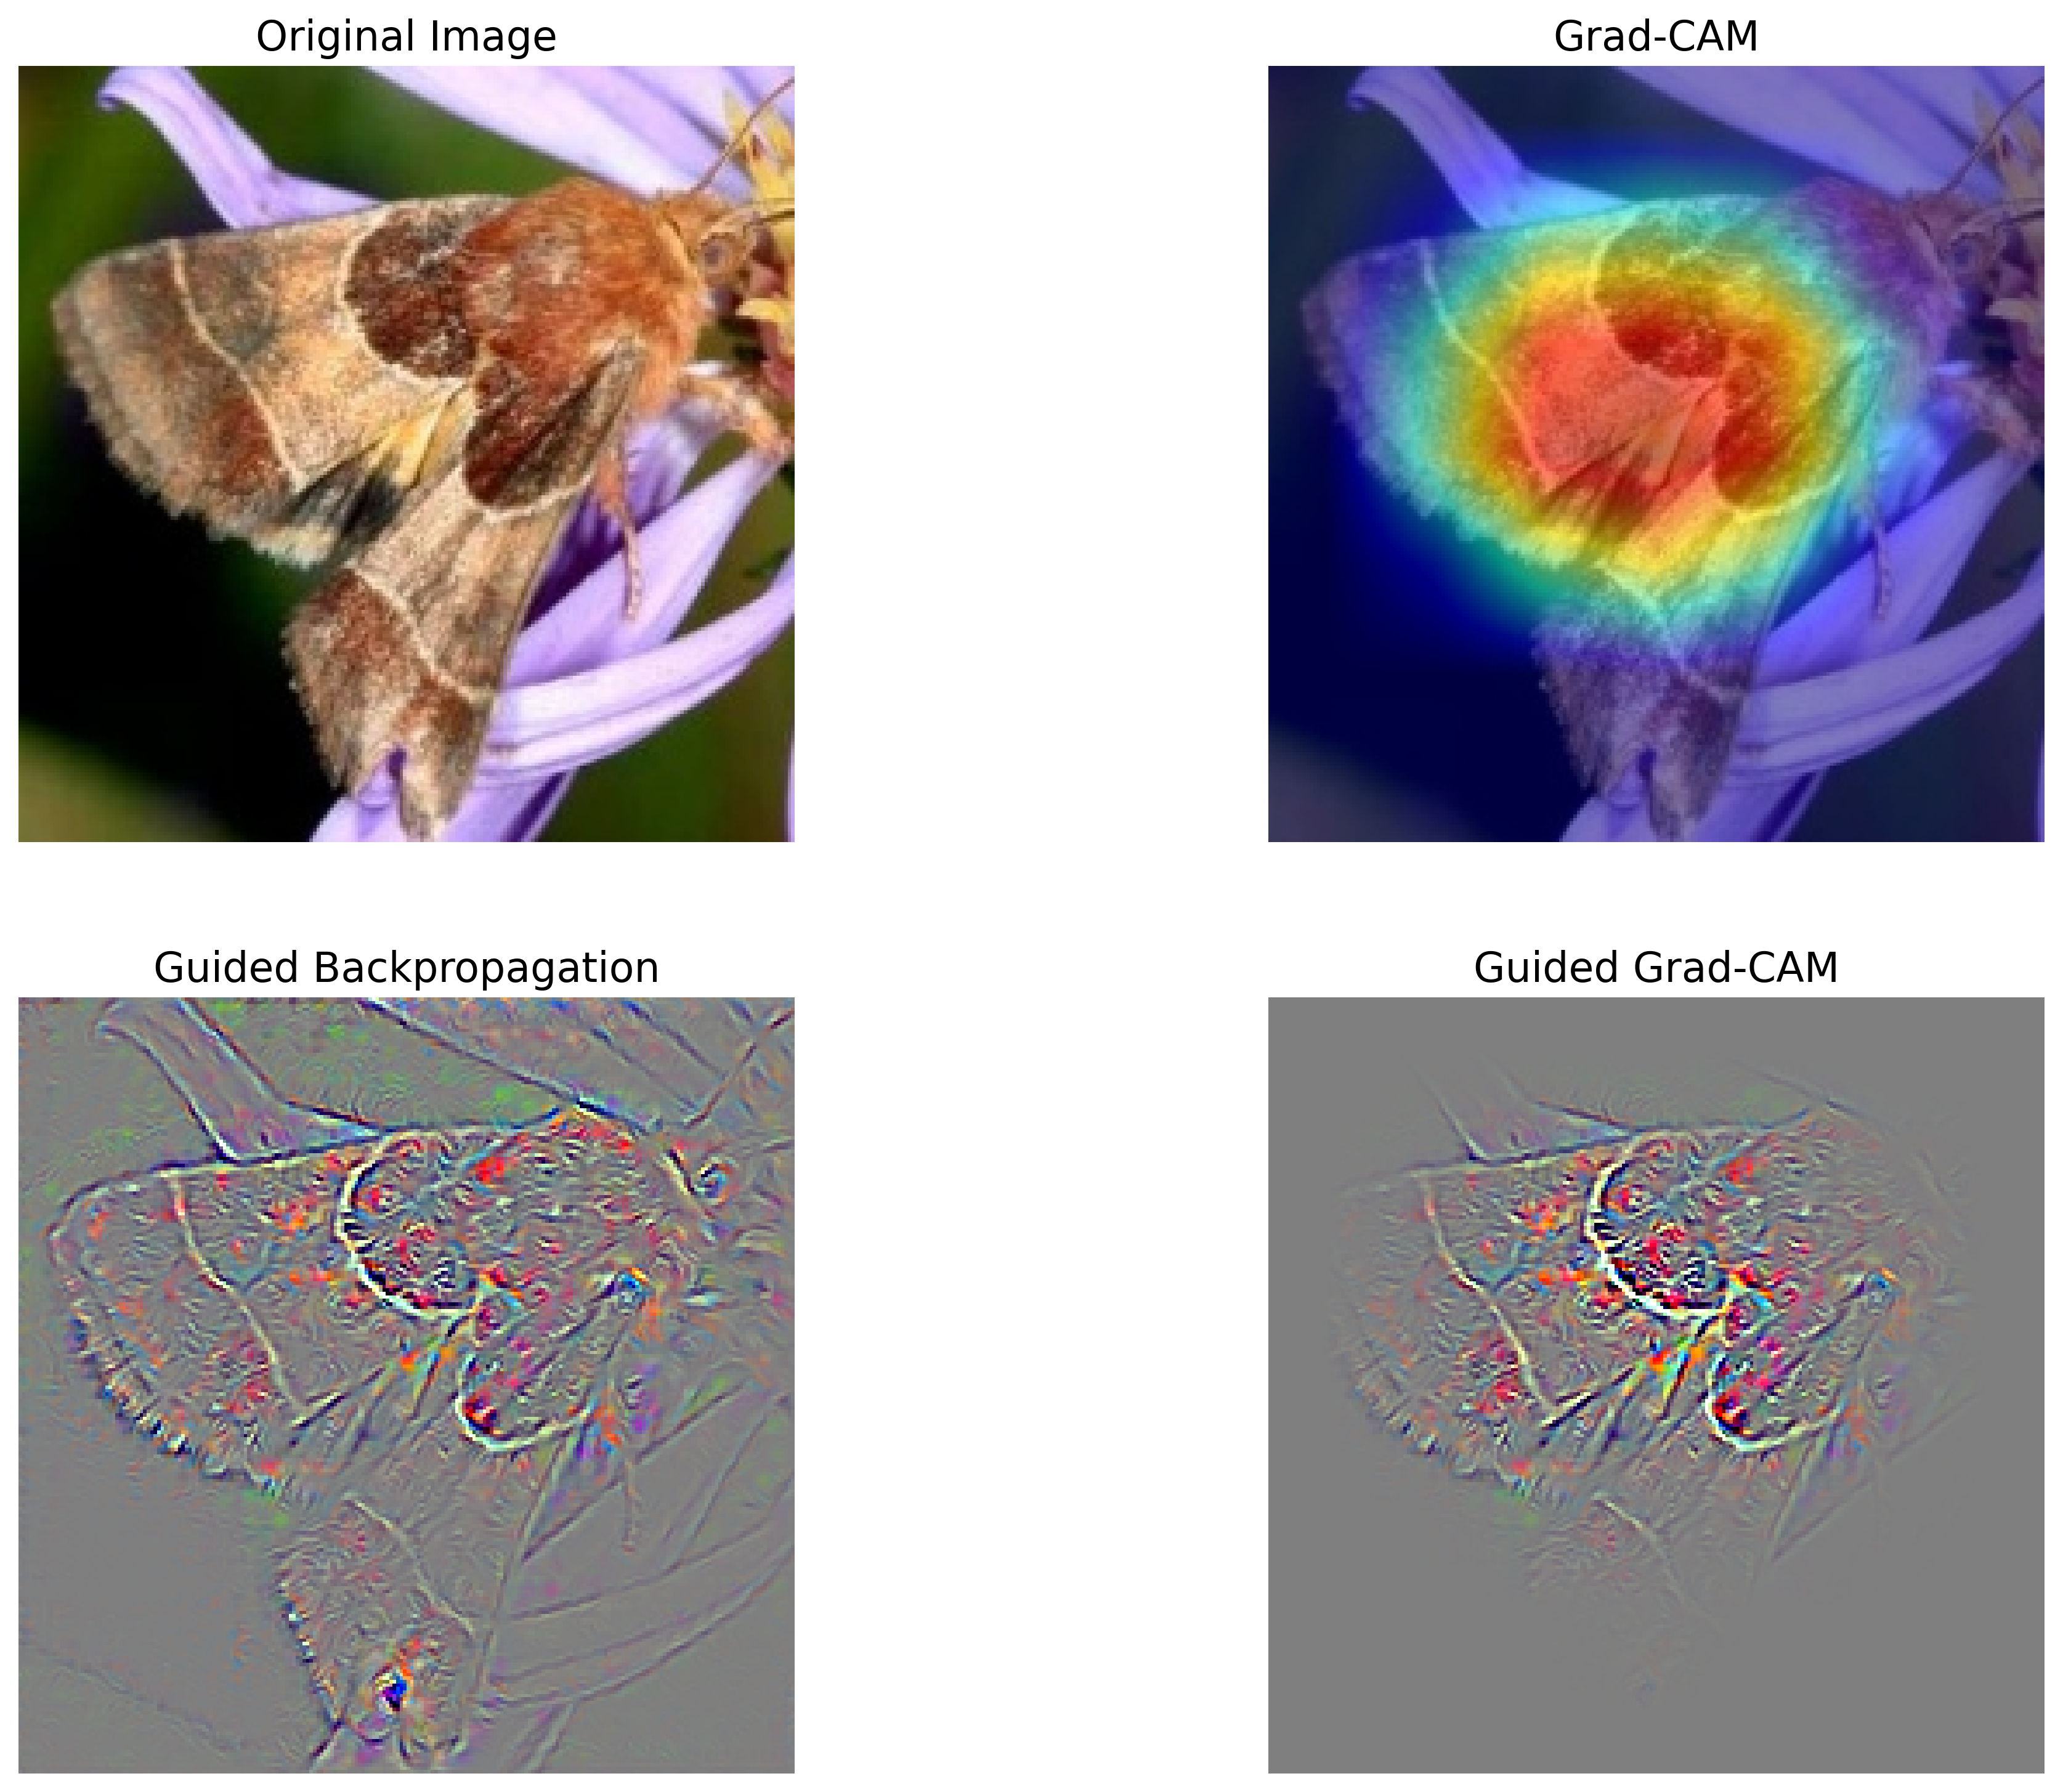

In [28]:
viz('moths/test/ARCIGERA_FLOWER_MOTH/1.jpg')

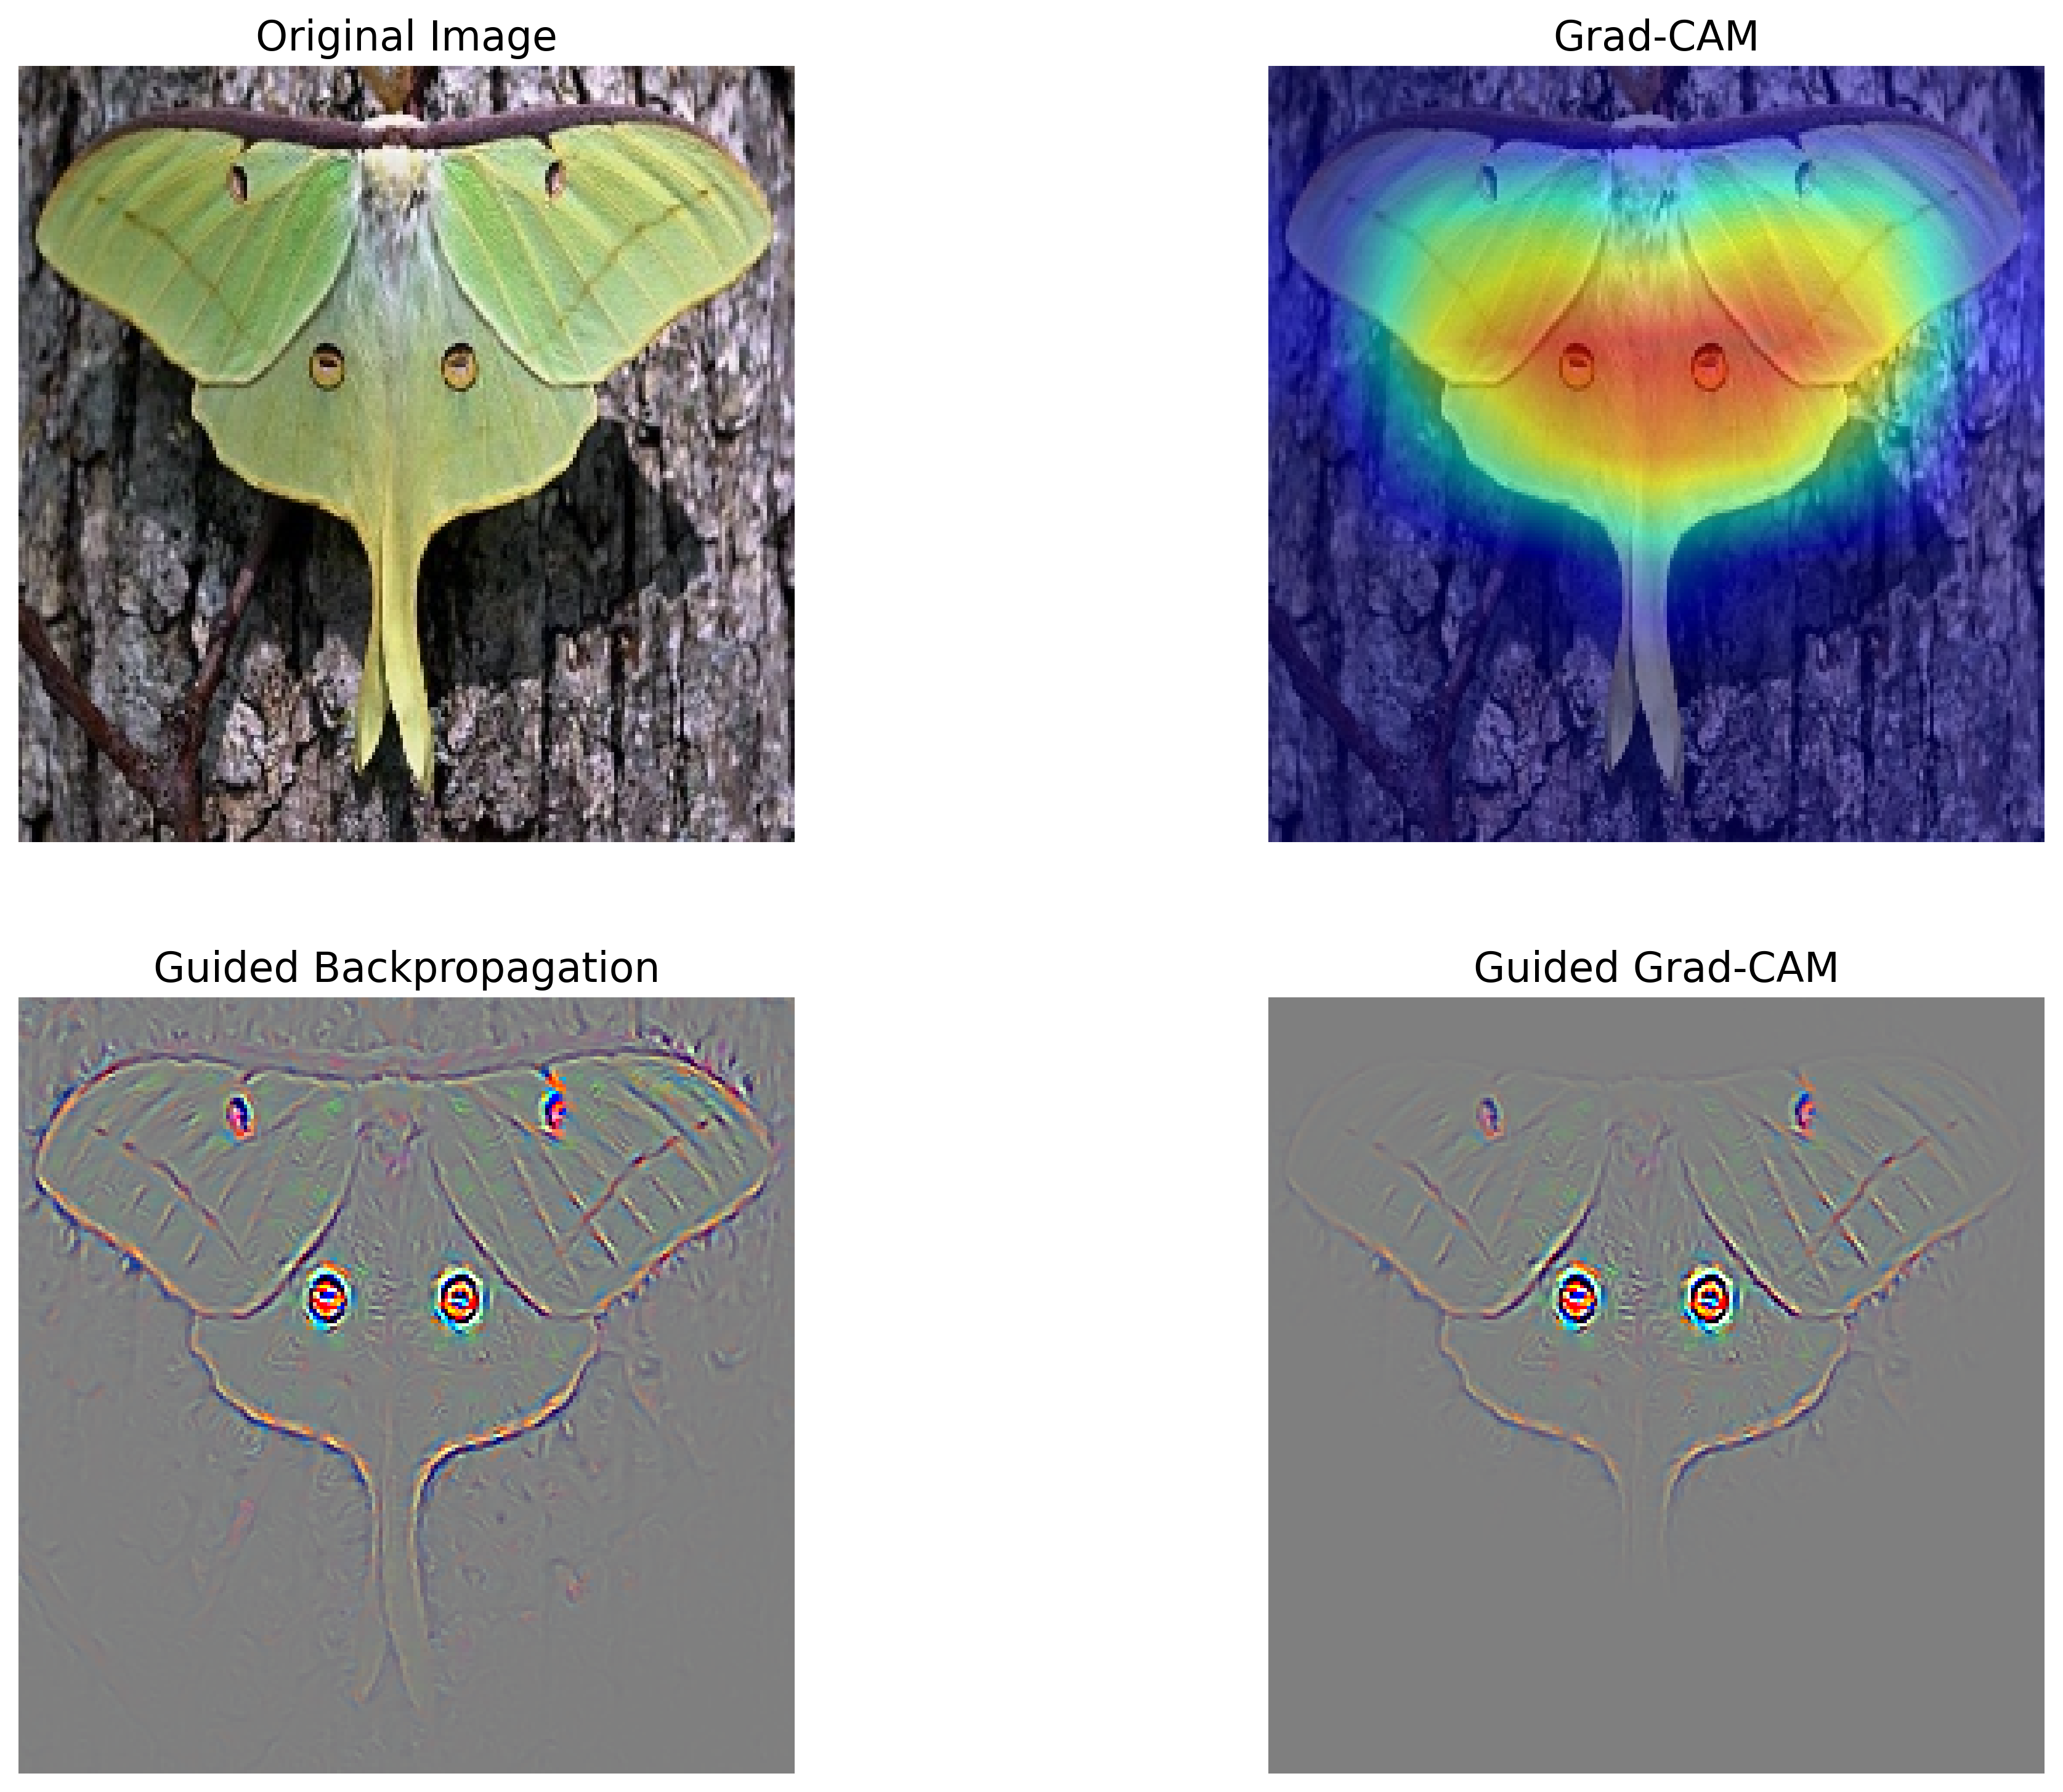

In [29]:
viz('moths/test/LUNA_MOTH/5.jpg')

In [ ]:
!rm -rf moths/trainvalid